In [1]:
# prepare forecasting model for retailer’s sales that would predict weekly sales for the next 8 weeks.
# You are asked to provide store-level sales forecasts as well as the network forecast.

### Data Summary
#### Stores
- Anonymized information about 45 stores, indicating the type and size of the store.
- Stores: are numbered 1 - 45
- Types: I see there are 3 types of stores A,B,C apparently categorical based on the size
- Size: I think it is the store capacity. Size is ranging from ~30k -220k

#### Features
Contains additional data related to the store, department, and regional activity for the given dates.
- Store: store number 1 - 45
- Date: Date of the week when the data was recorded 
- mperature: average temperature in the region
- Fuel_Price: cost of fuel in the region
- MarkDown1-5: - anonymized data related to promotional markdowns. MarkDown data is only available
after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA
- CPI: the consumer price index
- Unemployment: the unemployment rate
- IsHoliday: boolean, whether the week is a special holiday week

#### Sales
- Store - store number
- Dept - department number
- Date – week number
- Weekly_Sales - sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [2]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## Data Source: https://www.kaggle.com/manjeetsingh/retaildataset
# read the ['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv'] from the /data folder
import os
print("current directory is : " + os.getcwd()) 
print('the /data folder contains:') 
print(os.listdir("./data"))

stores = pd.read_csv('./data/stores data-set.csv')
features = pd.read_csv('./data/Features data set.csv')
sales = pd.read_csv('./data/sales data-set.csv')

current directory is : C:\Users\User\projects\retail_kaggle\retail_kaggle
the /data folder contains:
['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']


In [4]:
######## 1. Understand the data and cleanup ##############

In [5]:
######## 1.1 stores dataset ############### 
# many stores, categorical Type and the Size of the shop?
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


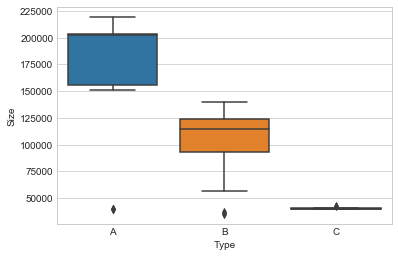

In [6]:
# Apparently there are 3 types of stores, each type belongs to a size range
sns.set_style('whitegrid')
sns.boxplot(x='Type',y='Size', data=stores)

In [7]:
# how many Stores are there / by Type ?
stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [8]:
print(stores.dtypes)

Store     int64
Type     object
Size      int64
dtype: object


In [9]:
# Is the dataset clean? Yes
stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [10]:
######## 1.2 features dataset ############### 

In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


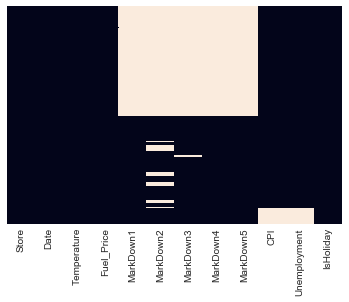

In [13]:
# get a grasp on how the missing data is distrubuted accros one store
# we already know that MarkDown data is only available after Nov 2011 and is not available for all stores all the time. 
# CPI and unemployment are missing sometimes, I can fill in NaN-s wit hthe last known value for that period
sns.heatmap(features[features['Store'].eq(1)].isnull(),cbar=False,yticklabels=False)

In [14]:
## I don't intend to use so instead of replacing na-s with 0 I better drop them all
markdown_cols = features.filter(like='MarkDown').columns
for column in markdown_cols:
     features = features.drop(column,axis=1)

In [15]:
# Is now the data clean? Yes
features.isna().sum()

Store             0
Date              0
Temperature       0
Fuel_Price        0
CPI             585
Unemployment    585
IsHoliday         0
dtype: int64

In [16]:
######## 1.3 Sales dataset ############### 

In [17]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [18]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [19]:
# Is the data clean? Yes
sales.isna().sum().sum()

0

In [20]:
######### 2. Join features and sales datasets ########################


In [21]:
# merge left all tables, use only keys from left frame, similar to a SQL left outer join; preserve key order.
    
retail = pd.merge(sales, features, how = 'left', on = ['Store', 'Date', 'IsHoliday'])
retail = pd.merge(retail, stores, how = 'left', on = ['Store'])

# format date in datetime, we need it to extract Year and Year week later to split the data in train, test
retail['Date'] = pd.to_datetime(retail['Date'])
retail['Year'] = pd.DatetimeIndex(retail['Date']).year
retail['Year-Week'] = retail['Date'].dt.strftime('%Y-%U')

# I noticed there are Sales figures that are 0 or even negative, cleanup:
retail = retail[retail['Weekly_Sales'].gt(0)]

# On features Fill na gaps forward on CPI and Unemployment, Data seems sorted by date already
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
retail['CPI'] = retail['CPI'].fillna(method='pad')
retail['Unemployment'] = retail['Unemployment'].fillna(method='pad')

# turn IsHoliday into an Integer, useful later for numeric computations
retail['IsHoliday'] = retail['IsHoliday'].astype(int)

# checkout the dataset we're going to use further
retail.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,0.070345,60.090599,3.360890,171.212496,7.960000,136749.732787,2010.968454
std,12.787236,30.508819,22729.492116,0.255729,18.447857,0.458519,39.162445,1.863879,60993.084568,0.796898
min,1.000000,1.000000,0.010000,0.000000,-2.060000,2.472000,126.064000,3.879000,34875.000000,2010.000000
25%,11.000000,18.000000,2120.130000,0.000000,46.680000,2.933000,132.022667,6.891000,93638.000000,2010.000000
50%,22.000000,37.000000,7661.700000,0.000000,62.090000,3.452000,182.350989,7.866000,140167.000000,2011.000000
75%,33.000000,74.000000,20271.265000,0.000000,74.280000,3.738000,212.445487,8.567000,202505.000000,2012.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,227.232807,14.313000,219622.000000,2012.000000


In [22]:
# make sure the dataset is clean
retail.isna().sum(axis = 0)

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Year-Week       0
dtype: int64

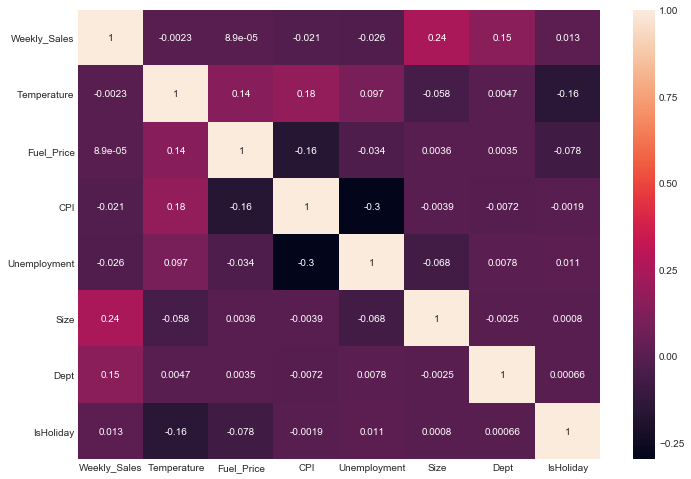

In [23]:
# Data analysis: visualisations, corr matrix for the numeric factors
col_features = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size', 'Dept', 'IsHoliday']
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(retail[col_features].corr(),annot=True)

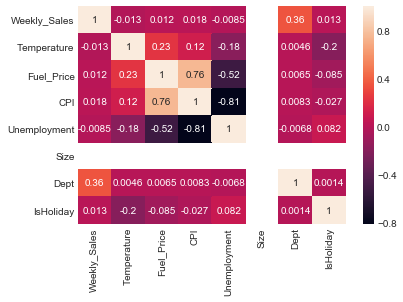

In [24]:
# how is the corr matrix when we use less data, just for one store?
sns.heatmap(retail[col_features][retail['Store'].eq(1)].corr(),annot=True)

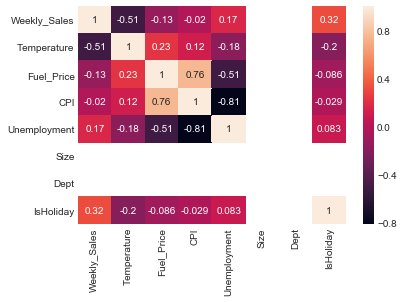

In [25]:
# how is the corr matrix when we use less data, just for one store dept?
sns.heatmap(retail[col_features][retail['Store'].eq(1) & retail['Dept'].eq(5)].corr(),annot=True)

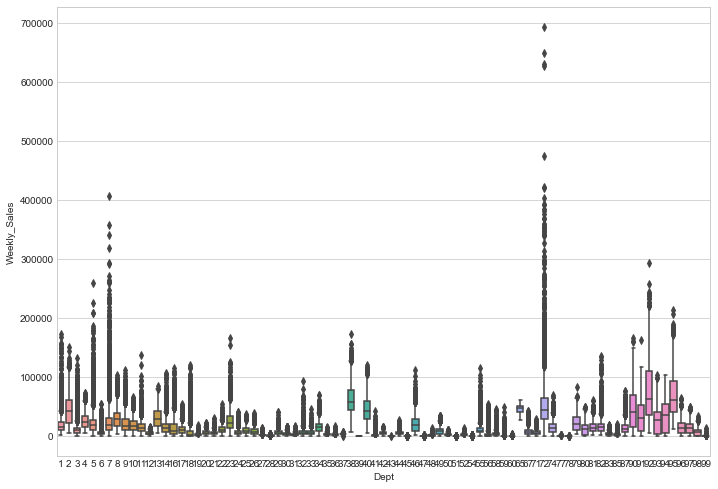

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x='Dept',y='Weekly_Sales',data=retail)
# fig.savefig('retail.png')

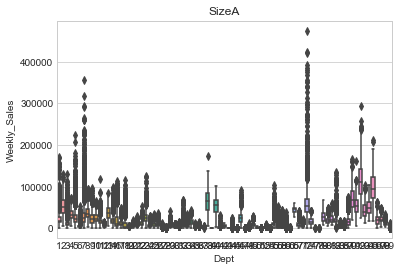

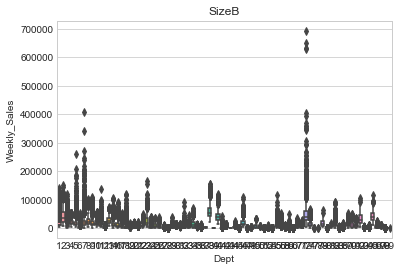

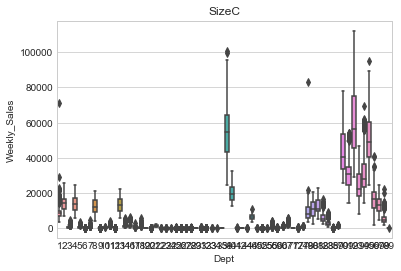

In [27]:
# See if the Distribution of Sales by dept differs for Store Type:
for store in retail['Type'].unique():
    fig = plt.figure()
    ax = plt.axes()
    fig.set_size_inches(6, 4)
    sns.boxplot(x='Dept',y='Weekly_Sales',data=retail[retail['Type']==store])
    ax.set_title('Size'+str(store))


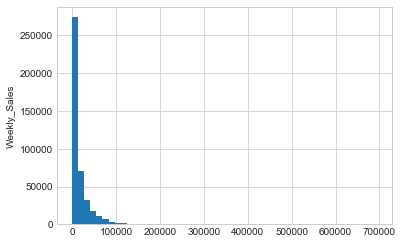

In [28]:
plt.hist(retail['Weekly_Sales'].values,  bins=50)
plt.ylabel('Weekly_Sales');

In [29]:
############# Numerical Predictions ############

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

col_X = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'Dept', 'IsHoliday']
col_y = ['Weekly_Sales']

X_train = retail[col_X][retail['Year'].isin([2010, 2011])]
X_test = retail[col_X][retail['Year'].isin([2012])]
y_train = retail[col_y][retail['Year'].isin([2010, 2011])]
y_test = retail[col_y][retail['Year'].isin([2012])]
        

In [31]:
# train Linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# generate predictions
y_test_pred = lin_reg.predict(X_test)
y_test_pred = pd.DataFrame(lin_reg.predict(X_test), index=X_test.index)

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#A non-negative floating point value (the best value is 0.0), 
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_test_pred))

446345379.3313437


In [33]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html
# Best possible score is 1.0, lower values are worse.
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_test, y_test_pred))

0.08970068149011379


In [34]:
print('Coefficients: \n', lin_reg.coef_)

Coefficients: 
 [[ 1.85555070e+01 -1.67570072e+02 -1.66100306e+01 -2.07397147e+02
   9.15420564e-02  1.07979153e+02  1.36690751e+03]]


In [35]:
# Linear regression for one shop one Dept

In [36]:
X_train_dept = retail[col_X][retail['Year'].isin([2010, 2011]) & retail['Store'].eq(1) & retail['Dept'].eq(1)]
X_test_dept = retail[col_X][retail['Year'].isin([2012]) & retail['Store'].eq(1) & retail['Dept'].eq(1)]
y_train_dept = retail[col_y][retail['Year'].isin([2010, 2011]) & retail['Store'].eq(1) & retail['Dept'].eq(1)]
y_test_dept = retail[col_y][retail['Year'].isin([2012]) & retail['Store'].eq(1) & retail['Dept'].eq(1)]
            

In [37]:
# train Linear regression
lin_reg_dept = LinearRegression()
lin_reg_dept.fit(X_train_dept, y_train_dept)

# generate predictions
y_test_pred_dept = lin_reg_dept.predict(X_test_dept)
print(mean_squared_error(y_test_dept, y_test_pred_dept))

142175266.6341782


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html
# Best possible score is 1.0, lower values are worse.
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_test_dept, y_test_pred_dept))

0.0936369770019686


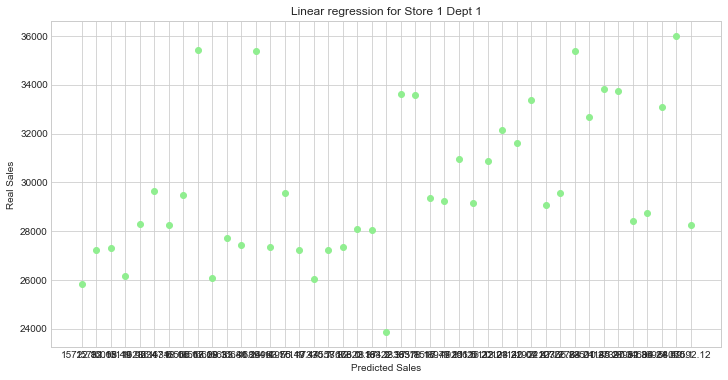

In [39]:
# Plot predictions using Linear Regression
plt.figure(figsize=(12,6))
plt.scatter(y_test_dept, y_test_pred_dept, c = "lightgreen", marker = "o", label = "Validation data")
plt.title("Linear regression for Store 1 Dept 1")
plt.xlabel("Predicted Sales")
plt.ylabel("Real Sales")
plt.show()

In [40]:
y_test_dept.join(pd.DataFrame(y_test_pred_dept,index=y_test_dept.index)).head()

,Weekly_Sales,0
100,16567.69,35432.289625
101,16894.40,35381.286477
102,18365.10,33623.643392
103,18378.16,33572.002763
104,23510.49,32673.816240


In [41]:
# predict weekly sales for the next 8 weeks.
# You are asked to provide store-level sales forecasts as well as the network forecast.
X_train_s = X_train_dept[8:]
X_test_s = X_test_dept[8:]
y_train_s = y_train_dept.shift(8)[8:]
y_test_s =  y_test_dept.shift(8)[8:]

# train Linear regression
lin_reg_s = LinearRegression()
lin_reg_s.fit(X_train_s, y_train_s)

# generate predictions
y_test_pred_s = lin_reg_s.predict(X_test_s)
print(mean_squared_error(y_test_s, y_test_pred_s))


702471750.333633


In [43]:
## loop through Stores
## loop through Dept
## Predict and sum the last 8 weeks per store 
## Sum all predictions

columns = ['Store','Dept', 'W1','W2','W3','W4','W5','W6','W7','W8','All']
results_df = pd.DataFrame(columns=columns)

i=0
#for store in range(1,3):
for store in retail['Store'].unique():
    dept_list=retail['Dept'][retail['Store'].eq(store)].unique()
    for dept in dept_list:
     
        i=i+1
        X_train_dept = retail[col_X][retail['Year'].isin([2010, 2011]) & retail['Store'].eq(store) & retail['Dept'].eq(dept)]
        X_test_dept = retail[col_X][retail['Year'].isin([2012]) & retail['Store'].eq(store) & retail['Dept'].eq(dept)]
        y_train_dept = retail[col_y][retail['Year'].isin([2010, 2011]) & retail['Store'].eq(store) & retail['Dept'].eq(dept)]
        y_test_dept = retail[col_y][retail['Year'].isin([2012]) & retail['Store'].eq(store) & retail['Dept'].eq(dept)]

        if X_test_dept.count()[1]>10 and X_train_dept.count()[1]>10:
        
            # predict weekly sales for the next 8 weeks.
            # You are asked to provide store-level sales forecasts as well as the network forecast.
            X_train_s = X_train_dept[8:]
            X_test_s = X_test_dept[8:]
            y_train_s = y_train_dept.shift(8)[8:]
            y_test_s =  y_test_dept.shift(8)[8:]

            # train Linear regression
            lin_reg_s = LinearRegression()
            lin_reg_s.fit(X_train_s, y_train_s)

            # generate predictions
            y_test_pred_s = lin_reg_s.predict(X_test_s)

            if len(y_test_pred_s)>10:
                store_forecast = y_test_pred_s[-9:-1].sum()
                results_df = results_df.append({"Store": store,'Dept':dept,
                                                'W1':y_test_pred_s[-8],
                                                'W2':y_test_pred_s[-7],
                                                'W3':y_test_pred_s[-6],
                                                'W4':y_test_pred_s[-5],
                                                'W5':y_test_pred_s[-4],
                                                'W6':y_test_pred_s[-3],
                                                'W7':y_test_pred_s[-3],
                                                'W8':y_test_pred_s[-1],
                                                'All':store_forecast
                                               }
                                               , ignore_index=True)



In [44]:
results_df = results_df.astype(float)
print("Store forecast weekly returns for the next 8 weeks:")
results_df.groupby('Store').sum(axis=0).astype(str)

Store forecast weekly returns for the next 8 weeks:


,Dept,W1,W2,W3,W4,W5,W6,W7,W8,All
Store,,,,,,,,,,
1.0,3236.0,1720045.4995485072,1702062.3955126437,1708184.5570687642,1697497.954849045,1778965.3583689872,1784627.7533489142,1784627.7533489142,1770543.4125938618,13859460.253959455
2.0,3236.0,1809316.417506414,1790277.109546821,1792729.0269663916,1745540.7075315062,1871015.3084202753,1884371.8453342183,1884371.8453342183,1838502.7678441037,14526564.381501142
3.0,2640.0,404685.589272328,400594.8528499089,406464.1606641031,395161.4944022105,411132.60608638165,412151.13127097517,412151.13127097517,399887.7785751886,3223190.053635055
4.0,3236.0,2129881.0012512207,2163642.233531046,2161335.170884229,2144153.4491442204,2189774.029374637,2215243.269227154,2215243.269227154,2177992.7273188056,17308115.59901356
5.0,2566.0,316699.76503526815,317625.86597606336,320942.27432087436,314896.0136208266,322876.80036983814,325632.90188456804,325632.90188456804,320390.1031731618,2554578.028698635
6.0,3236.0,1831445.6161954557,1760066.5566192332,1738885.0980538118,1739688.6080798353,1881637.8598359325,1858795.6429200494,1858795.6429200494,1862575.4809113343,14456781.282764364
7.0,3126.0,559792.3921573746,585985.3737905913,594188.7431349964,599920.5111835853,587192.2537286993,598570.5534570753,598570.5534570753,598780.4197100902,4699976.567292866
8.0,3092.0,1002213.0972574197,993986.9177753734,991570.663557103,977155.9549207583,1040958.2494621158,1045339.3611838911,1045339.3611838911,1021129.2076556609,8062807.344568087
9.0,2532.0,599072.044811412,591660.3579371865,592853.370173003,584387.7993161704,613418.8699589721,615476.8208874714,615476.8208874714,606283.6880705854,4792851.433527724


In [46]:
# Sum Sales forecast for the entire network
print("Network forecast weekly returns for the next 8 weeks:")
results_df['All'].sum(axis=0)

Network forecast weekly returns for the next 8 weeks:


355064733.2126678